device: cuda
Start Training Improved Model...
Epoch [1/15] LR=1.0e-04 Train Loss=0.4618 Acc=0.7757 | Val Loss=0.3524 Acc=0.8423
  >>> Best model updated! Val Acc: 0.8423
Epoch [2/15] LR=1.0e-04 Train Loss=0.2232 Acc=0.9110 | Val Loss=0.3904 Acc=0.8563
  >>> Best model updated! Val Acc: 0.8563
Epoch [3/15] LR=1.0e-04 Train Loss=0.1318 Acc=0.9514 | Val Loss=0.3580 Acc=0.8713
  >>> Best model updated! Val Acc: 0.8713
Epoch [4/15] LR=1.0e-04 Train Loss=0.0825 Acc=0.9716 | Val Loss=0.4605 Acc=0.8597
Epoch [5/15] LR=1.0e-05 Train Loss=0.0574 Acc=0.9780 | Val Loss=0.2772 Acc=0.9050
  >>> Best model updated! Val Acc: 0.9050
Epoch [6/15] LR=1.0e-05 Train Loss=0.0281 Acc=0.9906 | Val Loss=0.2775 Acc=0.9093
  >>> Best model updated! Val Acc: 0.9093
Epoch [7/15] LR=1.0e-05 Train Loss=0.0191 Acc=0.9950 | Val Loss=0.2635 Acc=0.9157
  >>> Best model updated! Val Acc: 0.9157
Epoch [8/15] LR=1.0e-05 Train Loss=0.0128 Acc=0.9983 | Val Loss=0.2674 Acc=0.9173
  >>> Best model updated! Val Acc: 0.9173
Epoc

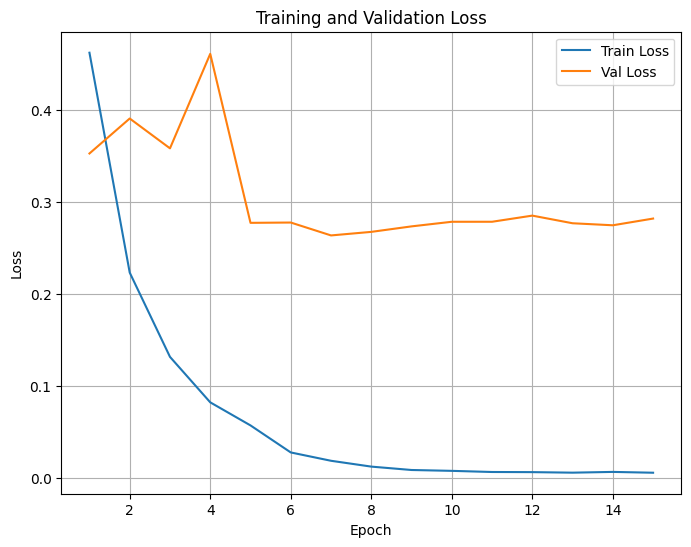

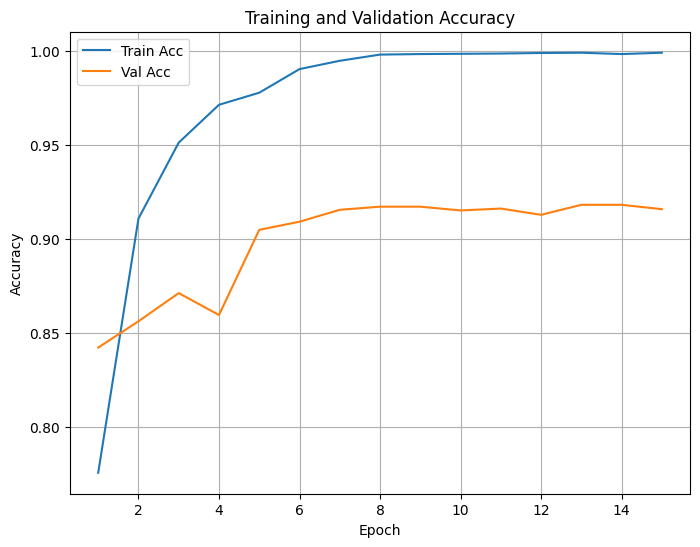


🎨 Loading best model for Visualization...
🔎 Analyzing Image Index: 1315


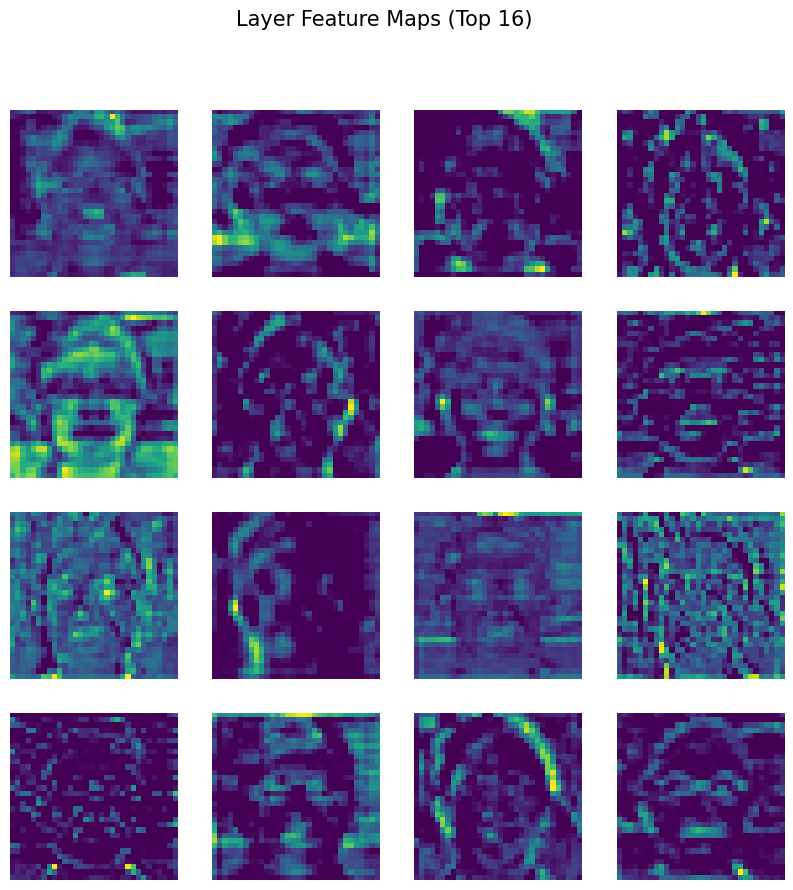

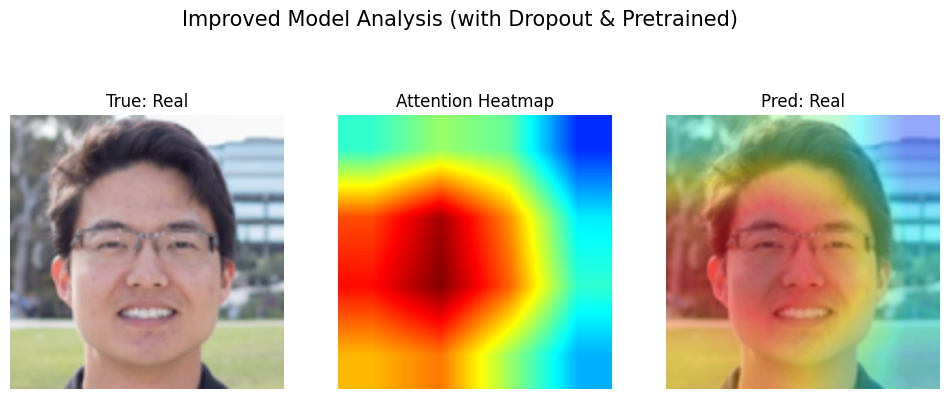

In [2]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from datetime import datetime

# 引入你的数据加载模块
from dataloader import *

# ====================================================
# [改进] 自定义模型结构: FaceResNet
# ====================================================
class FaceResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(FaceResNet, self).__init__()
        # 1. 使用预训练权重 (Transfer Learning)
        # 注意：PyTorch 1.8 使用 pretrained=True
        self.backbone = models.resnet18(pretrained=True)
        
        # 2. 获取 backbone 的输出特征维度 (ResNet18 是 512)
        in_features = self.backbone.fc.in_features
        
        # 移除原有的全连接层，为了方便后续提取特征，我们只保留卷积部分作为 backbone
        # 这里的 trick 是把 backbone 的 fc 替换成 Identity (不做任何处理)，或者在 forward 里重写
        self.backbone.fc = nn.Identity() 

        # 3. [结构改进] 重构分类头 (Classifier Head)
        # 增加 Dropout 防止过拟合，增加中间层提升表达能力
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 256),      # 增加一个隐藏层 512 -> 256
            nn.ReLU(),
            nn.Dropout(p=0.5),                # [关键] 丢弃 50% 神经元，强力抗过拟合
            nn.Linear(256, num_classes)       # 最终输出 256 -> 2
        )

    def forward(self, x):
        # 先经过卷积层提取特征
        features = self.backbone(x) 
        # 再经过自定义的分类头
        out = self.classifier(features)
        return out

# ====================================================
# 可视化工具类 (适配新模型结构)
# ====================================================
class FeatureMapVisualizer:
    def __init__(self, model, target_layer):
        self.model = model
        self.feature_maps = []
        target_layer.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.feature_maps.append(output.detach())

    def visualize(self, input_tensor):
        self.feature_maps = []
        # 注意：这里只跑 backbone 也可以，或者跑全模型
        _ = self.model(input_tensor)
        if not self.feature_maps: return

        fmap = self.feature_maps[0].cpu().squeeze(0)
        num_channels = min(16, fmap.shape[0])
        
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        fig.suptitle(f"Layer Feature Maps (Top {num_channels})", fontsize=15)
        
        for i in range(num_channels):
            ax = axes[i // 4, i % 4]
            img = fmap[i].numpy()
            img = (img - img.min()) / (img.max() - img.min() + 1e-9)
            ax.imshow(img, cmap='viridis')
            ax.axis('off')
        plt.show()

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[0, class_idx].backward()
        
        gradients = self.gradients
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        activations = self.activations.detach()
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu().numpy(), 0)
        heatmap /= (np.max(heatmap) + 1e-9)
        return heatmap, class_idx

def show_cam_result(raw_img_pil, heatmap, pred_label="", true_label=""):
    raw_img_pil = raw_img_pil.resize((256, 256))
    heatmap = cv2.resize(heatmap, (256, 256))
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
    
    superimposed = heatmap_color * 0.4 + np.array(raw_img_pil) * 0.6
    superimposed = np.clip(superimposed, 0, 255).astype(np.uint8)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1); plt.imshow(raw_img_pil); plt.title(f"True: {true_label}"); plt.axis('off')
    plt.subplot(1, 3, 2); plt.imshow(heatmap_color); plt.title("Attention Heatmap"); plt.axis('off')
    plt.subplot(1, 3, 3); plt.imshow(superimposed); plt.title(f"Pred: {pred_label}"); plt.axis('off')
    plt.suptitle("Improved Model Analysis (with Dropout & Pretrained)", fontsize=15)
    plt.show()

# ====================================================
# 1. 初始化配置
# ====================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
writer = SummaryWriter('runs/resnet18_improved_experiment')

# [改进] 初始化我们自定义的改进版模型
model = FaceResNet(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
# [改进] 降低学习率，因为我们使用了预训练权重，不需要那么大的步子
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3) 
# [改进] 学习率调度器：每 5 个 epoch 学习率乘以 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# ====================================================
# 2. 训练与评估函数
# ====================================================
def train_one_epoch(model, loader, optimizer, criterion, device, epoch_index):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (imgs, labels) in enumerate(loader):
        imgs = imgs.to(device)
        labels = labels.to(device).long()

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        
        if i % 10 == 0:
            global_step = (epoch_index - 1) * len(loader) + i
            writer.add_scalar('Loss/train_step', loss.item(), global_step)

    return running_loss / total, correct / total

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device).long()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return running_loss / total, correct / total

# ====================================================
# 3. 主循环
# ====================================================
num_epochs = 15 # 由于有预训练，通常需要的 epoch 更少
best_val_acc = 0.0
# 在文件名中添加时间戳
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_path = f"improved_resnet18_{timestamp}.pth"

# 用于记录每个 epoch 的 loss 和 acc
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print(f"Start Training Improved Model...")

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch)
    val_loss,   val_acc   = evaluate(model, valid_loader, criterion, device)
    
    # [新增] 更新学习率
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch [{epoch}/{num_epochs}] LR={current_lr:.1e} "
          f"Train Loss={train_loss:.4f} Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f} Acc={val_acc:.4f}")

    writer.add_scalar('Loss/train_epoch', train_loss, epoch)
    writer.add_scalar('Accuracy/train_epoch', train_acc, epoch)
    writer.add_scalar('Loss/val_epoch', val_loss, epoch)
    writer.add_scalar('Accuracy/val_epoch', val_acc, epoch)

    # 记录 loss 和 acc 曲线
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)
        print(f"  >>> Best model updated! Val Acc: {best_val_acc:.4f}")

writer.close()
print("\n✅ Training Finished!")

# 训练完成后绘制 Loss 曲线
epochs_list = range(1, num_epochs + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs_list, train_losses, label='Train Loss')
plt.plot(epochs_list, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# 再绘制 Accuracy 曲线
plt.figure(figsize=(8, 6))
plt.plot(epochs_list, train_accs, label='Train Acc')
plt.plot(epochs_list, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# ====================================================
# 4. 可视化分析
# ====================================================
print("\n🎨 Loading best model for Visualization...")
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()

try:
    idx = random.randint(0, len(valid_dataset)-1)
    print(f"🔎 Analyzing Image Index: {idx}")
    img_tensor, label_idx = valid_dataset[idx]
    
    # 准备数据
    inv_tensor = img_tensor * 0.5 + 0.5
    inv_tensor = torch.clamp(inv_tensor, 0, 1)
    raw_img_pil = transforms.ToPILImage()(inv_tensor)
    input_tensor = img_tensor.unsqueeze(0).to(device)
    class_names = {0: 'Fake', 1: 'Real'}
    
    # 1. 特征图 (查看 layer1)
    # 注意：因为我们将 resnet 封装在 self.backbone 里，所以访问路径变了
    viz_feat = FeatureMapVisualizer(model, model.backbone.layer1)
    viz_feat.visualize(input_tensor)

    # 2. Grad-CAM (查看 layer4)
    # 同样，路径变为 model.backbone.layer4
    grad_cam = GradCAM(model, model.backbone.layer4)
    heatmap, pred_idx = grad_cam.generate(input_tensor)
    
    show_cam_result(raw_img_pil, heatmap, 
                   pred_label=class_names.get(pred_idx, str(pred_idx)), 
                   true_label=class_names.get(label_idx, str(label_idx)))

except Exception as e:
    print(f"❌ Visualization Failed: {e}")